# Assignment 3 - [student name]_[student ID]

It is your turn to design the structure of the work.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# Import necessary libraries

import os, json, shutil, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score, recall_score,f1_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

# Data Preprocessing

In [ ]:
# Set your data directories and parameters
train_data_dir = 'dataset/train'
test_data_dir = 'dataset/test'
class_map_path = "dataset/class_map.json"

In [ ]:
total_images = 0
data = []

for cls in os.listdir(train_data_dir):
    cls_folder = os.path.join(train_data_dir, cls)

    if os.path.isdir(cls_folder):
        imgs = [f for f in os.listdir(cls_folder) if f.lower().endswith('.jpg')]
        print(f"{cls}: {len(imgs)} images")
        total_images += len(imgs)

        # ADD images to dataframe list
        for img_name in imgs:
            full_path = os.path.join(cls_folder, img_name)
            data.append([cls, full_path])

# Create dataframe
df = pd.DataFrame(data, columns=["label", "filepath"])

print("\nDataFrame Preview:")
print(df.head())

print("\nTotal images in DataFrame:", len(df))
print("Classes:", df['label'].unique())

print("\nTotal training images:", total_images)


basophil: 400 images
eosinophil: 400 images
erythroblast: 400 images
ig: 400 images
lymphocyte: 400 images
monocyte: 400 images
neutrophil: 400 images
platelet: 400 images

DataFrame Preview:
      label                              filepath
0  basophil  dataset/train\basophil\BA_101381.jpg
1  basophil  dataset/train\basophil\BA_107876.jpg
2  basophil  dataset/train\basophil\BA_112418.jpg
3  basophil  dataset/train\basophil\BA_114899.jpg
4  basophil  dataset/train\basophil\BA_119883.jpg

Total images in DataFrame: 3200
Classes: ['basophil' 'eosinophil' 'erythroblast' 'ig' 'lymphocyte' 'monocyte'
 'neutrophil' 'platelet']

Total training images: 3200


## Image Visualization

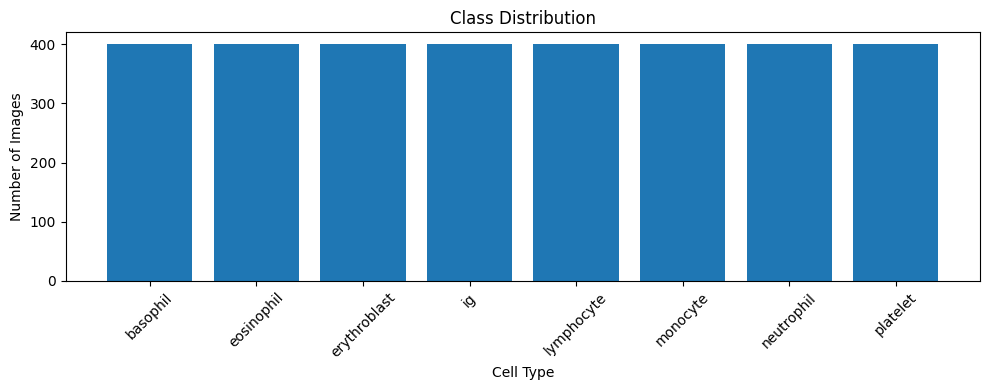

In [ ]:
# count images per class
# this checks if dataset is imbalanced
counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(10,4))
plt.bar(counts.index, counts.values)
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.xlabel("Cell Type")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


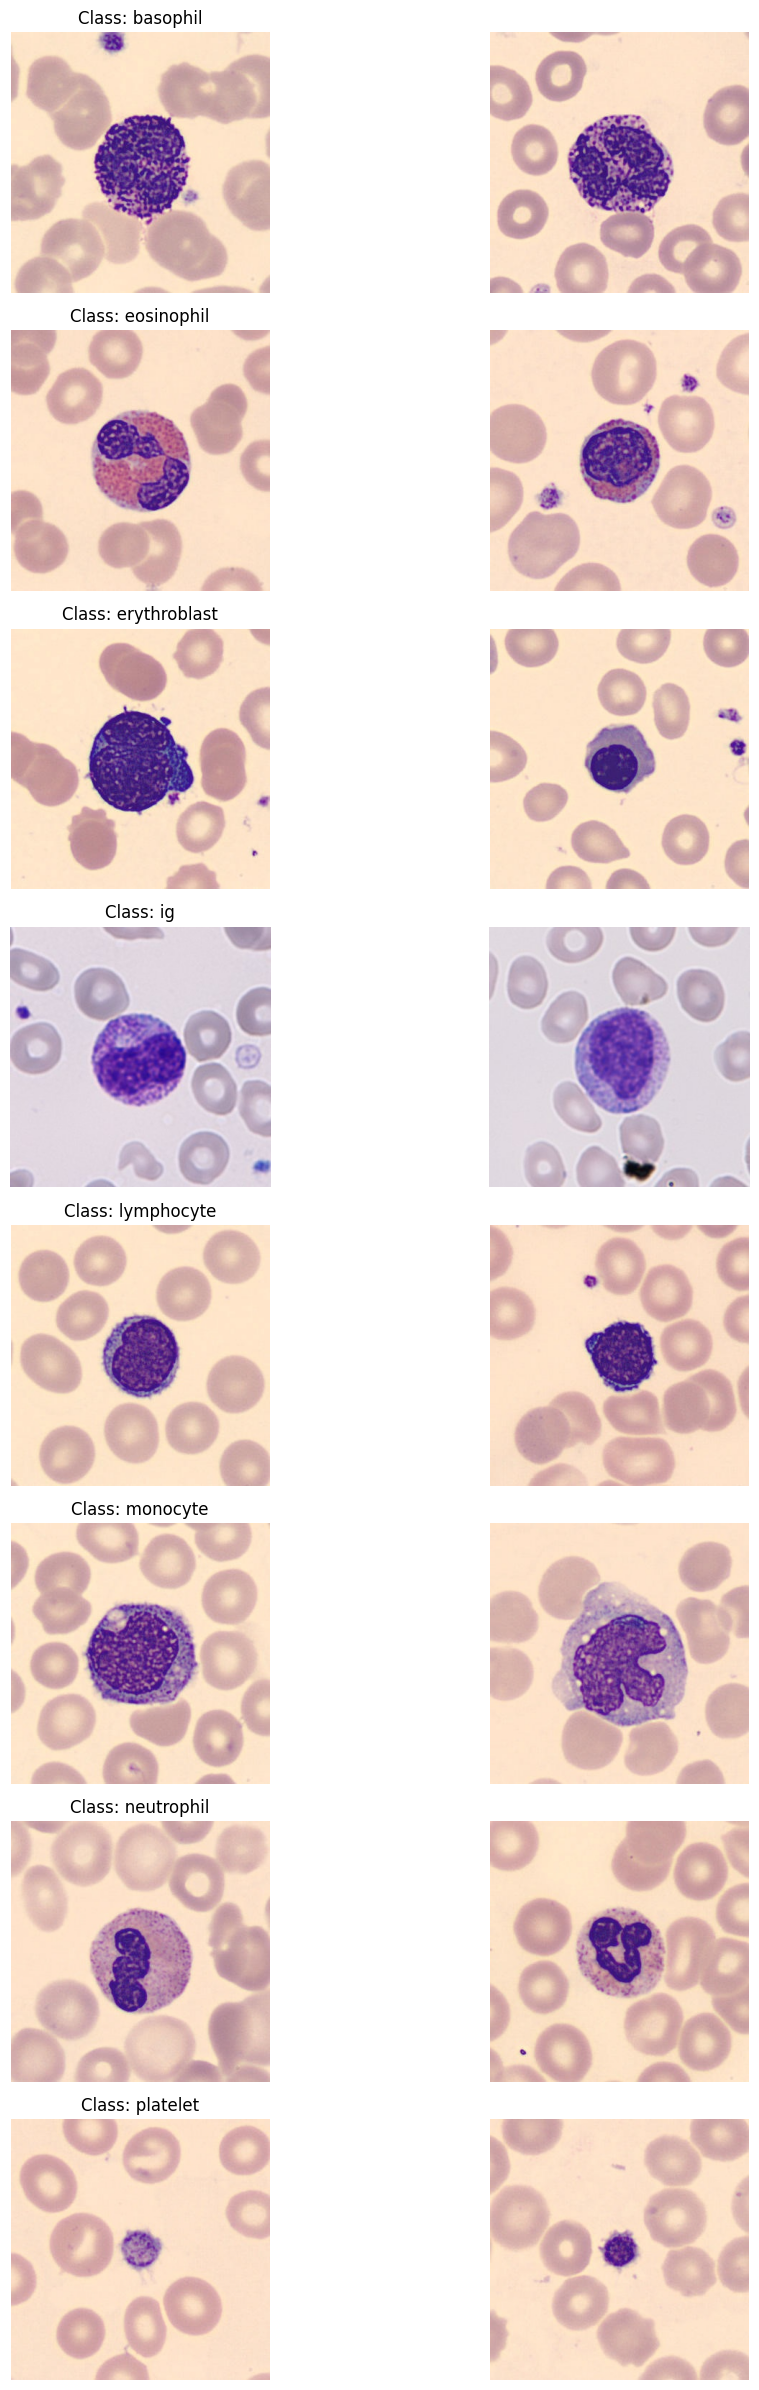

In [ ]:
# show up to 2 images per class for visual inspection
classes = sorted(df['label'].unique())

plt.figure(figsize=(12, 3 * len(classes)))

for i, cls_name in enumerate(classes):
    # take first 2 images of this class
    sample_paths = df[df['label']==cls_name]['filepath'].tolist()[:2]

    for j, img_path in enumerate(sample_paths):
        ax = plt.subplot(len(classes), 2, i*2 + j + 1)

        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)
        ax.axis('off')

        # title on first column only
        if j == 0:
            ax.set_title(f"Class: {cls_name}")

plt.tight_layout()
plt.show()


## Image Normalization

In [ ]:
# List of class folders
class_folders = os.listdir(train_data_dir)

# Iterate through class folders
for class_folder in class_folders:
    input_folder = os.path.join(train_data_dir, class_folder)

    # Resize images and save them in the SAME folder
    for filename in os.listdir(input_folder):
        image_path = os.path.join(input_folder, filename)

        # Load the image using PIL
        image = Image.open(image_path)

        # Resize the image to 224x224
        target_size = (224, 224)
        image = image.resize(target_size)

        # Save back to same path
        image.save(image_path)

print("Resized images done")


Resized images done


## Image Enhancement

In [ ]:
import cv2
import os


dataset_dir = train_data_dir

# Detect classes automatically
classes = [class_name for class_name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, class_name))]

# Define the NLM filter function
def nlm_filter(image):
    # Parameters: h=10, hColor=10, templateWindowSize=7, searchWindowSize=21
    filtered_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return filtered_image

# Iterate through each class
for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)

    # List all image files in the class directory
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith('.jpg')]

    # Apply NLM filtering to each image and overwrite
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)

        # Load the image using OpenCV
        image = cv2.imread(image_path)

        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply NLM filter
        filtered_image = nlm_filter(image_rgb)

        # Convert back to BGR for saving
        filtered_bgr = cv2.cvtColor(filtered_image, cv2.COLOR_RGB2BGR)

        # Overwrite the original image
        cv2.imwrite(image_path, filtered_bgr)

print("Noise removal from all images completed.")


KeyboardInterrupt: 

## Image Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import Image
import os

# Base folders
input_base_folder = 'dataset/train'
output_base_folder = 'dataset_aug/train'
os.makedirs(output_base_folder, exist_ok=True)

# Find class folders
class_folders = [c for c in os.listdir(input_base_folder) if os.path.isdir(os.path.join(input_base_folder, c))]

# Loop through each class folder
for class_name in class_folders:

    input_folder = os.path.join(input_base_folder, class_name)
    output_folder = os.path.join(output_base_folder, class_name + "_aug")
    os.makedirs(output_folder, exist_ok=True)

    # Augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        rescale=1./255
    )

    for filename in os.listdir(input_folder):
        image_path = os.path.join(input_folder, filename)

         # Load the image
        image = load_img(image_path)
        image = image.resize((224, 224))

        # Convert to array and reshape
        image_array = img_to_array(image)
        image_array = image_array.reshape((1,) + image_array.shape)

         # Flow generator
        augmented_images = datagen.flow(
            image_array,
            batch_size=16,
            save_to_dir=output_folder,
            save_prefix='augmented',
            save_format='png'
        )


         # Generate 5 augmented images
        num_augmented_images = 5
        for i, augmented_image in enumerate(augmented_images):
            if i >= num_augmented_images:
                break

            augmented_image_pil = Image.fromarray((augmented_image[0] * 255).astype('uint8'))

            save_filename = f'{filename.split(".")[0]}_{i}.png'
            save_path = os.path.join(output_folder, save_filename)
            augmented_image_pil.save(save_path)


    print(f"Augmented images saved for class: {class_name}")

print("\nAugmentation completed for ALL classes.")


In [ ]:

# Set your data directory
data_dir = 'dataset_aug'

# Define the directory names for the splits
train_dir = 'New_dataset/train'
val_dir = 'New_dataset/validation'
test_dir = 'New_dataset/test'

# Create the directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the ratio for splitting
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Loop through each class in the dataset
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        # List all the files in the class directory
        files = os.listdir(class_dir)
        random.shuffle(files)  # Shuffle the files

        num_files = len(files)

        # Calculate the number of samples for each split
        num_train = int(train_ratio * num_files)
        num_val = int(val_ratio * num_files)
        num_test = num_files - num_train - num_val

        # Create subdirectories for each split
        class_train_dir = os.path.join(train_dir, class_name)
        class_val_dir = os.path.join(val_dir, class_name)
        class_test_dir = os.path.join(test_dir, class_name)

        os.makedirs(class_train_dir, exist_ok=True)
        os.makedirs(class_val_dir, exist_ok=True)
        os.makedirs(class_test_dir, exist_ok=True)

        # Copy files to respective splits
        for i, file in enumerate(files):
            src_path = os.path.join(class_dir, file)
            if i < num_train:
                dst_path = os.path.join(class_train_dir, file)
            elif i < num_train + num_val:
                dst_path = os.path.join(class_val_dir, file)
            else:
                dst_path = os.path.join(class_test_dir, file)

            shutil.copy(src_path, dst_path)

print("New_dataset split into train, validation, and test sets.")


In [38]:

# Set device and enable cuDNN benchmarking for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Enable cuDNN auto-tuner for speed optimization
print(f"Using device: {device}")

# Add normalization using ImageNet mean/std values for better convergence, resize to 128x128 for faster training
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_tf = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define a simple CNN architecture with 4 convolutional blocks adjusted for 128x128 input
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        # Feature extraction layers with increasing channel depth
        self.features = nn.Sequential(
            # Block 1: Extract low-level features, reduce spatial size from 128→64
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2: Extract mid-level features, reduce size from 64→32
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3: Extract high-level features, reduce size from 32→16
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 4: Extract complex features, reduce size from 16→8
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Classification layers adjusted for 8x8 feature maps (256 * 8 * 8 = 16384)
        self.classifier = nn.Sequential(
            nn.Flatten(),                      # Flatten 3D features to 1D vector
            nn.Linear(256 * 8 * 8, 512),       # Fully connected layer (updated for 128x128 input)
            nn.ReLU(),
            nn.Dropout(0.5),                   # Dropout to prevent overfitting
            nn.Linear(512, num_classes)        # Output layer with num_classes neurons
        )

    def forward(self, x):
        # Pass input through feature extraction then classification
        x = self.features(x)
        x = self.classifier(x)
        return x

Using device: cuda


In [39]:
# Load datasets from directories using ImageFolder
train_data = datasets.ImageFolder("/content/drive/MyDrive/New_dataset/train", transform=train_transform)
val_data   = datasets.ImageFolder("/content/drive/MyDrive/New_dataset/validation", transform=val_transform)
test_data  = datasets.ImageFolder("/content/drive/MyDrive/New_dataset/test", transform=test_tf)

# Create data loaders with optimized settings for faster GPU training
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

# Initialize model with the correct number of output classes
num_classes = len(train_data.classes)
model = SimpleCNN(num_classes).to(device)

print(f"Found {len(train_data.samples)} images belonging to {len(train_data.classes)} classes.")
print(f"Found {len(val_data.samples)} images belonging to {len(val_data.classes)} classes.")
print(f"Found {len(test_data.samples)} images belonging to {len(test_data.classes)} classes.")

Found 23125 images belonging to 8 classes.
Found 4965 images belonging to 8 classes.
Found 4963 images belonging to 8 classes.


In [48]:
# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

from tqdm import tqdm
import time

def train_model(model, optimizer, criterion, epochs=10):
   # Training function that trains the model and tracks best validation accuracy with loss history
    model.to(device)
    best_val_acc = 0.0
    best_model_path = "best_cnn_model.pth"

    # Lists to store training history
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    # Get total batches for formatting
    total_train_batches = len(train_loader)
    total_val_batches = len(val_loader)

    for ep in range(epochs):
        epoch_start = time.time()

        # TRAINING PHASE
        model.train()  #Set model to training mode
        run_loss, correct, total = 0, 0, 0

        # Training with single progress bar
        with tqdm(total=total_train_batches,
                  desc=f"Epoch {ep+1}/{epochs}",
                  bar_format='{desc} {n_fmt}/{total_fmt} {bar} {elapsed} {rate_fmt}',
                  ncols=120) as pbar:

            for batch_idx, (imgs, lbls) in enumerate(train_loader):
                imgs, lbls = imgs.to(device, non_blocking=True), lbls.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True) # Clear gradients from previous step
                outs = model(imgs)    # Forward pass
                loss = criterion(outs, lbls) # Calculate loss
                loss.backward() # Backward pass
                optimizer.step() # Update weights

                # Track metrics
                run_loss += loss.item() * imgs.size(0)
                _, pred = outs.max(1)
                total += lbls.size(0)
                correct += pred.eq(lbls).sum().item()

                pbar.update(1)

        # Calculate training metrics
        ep_train_loss = run_loss / total
        ep_train_acc = correct / total

        # VALIDATION PHASE
        model.eval()  #Set model to evaluation mode
        val_loss, val_corr, val_total = 0.0, 0, 0

        with torch.no_grad():
            for v_imgs, v_lbls in val_loader:
                v_imgs, v_lbls = v_imgs.to(device, non_blocking=True), v_lbls.to(device, non_blocking=True)
                v_outs = model(v_imgs)
                v_loss = criterion(v_outs, v_lbls)

                val_loss += v_loss.item() * v_imgs.size(0)
                _, v_pred = v_outs.max(1)
                val_total += v_lbls.size(0)
                val_corr += v_pred.eq(v_lbls).sum().item()

        # Calculate validation metrics
        ep_val_loss = val_loss / val_total
        ep_val_acc = val_corr / val_total

        # Store metrics
        train_losses.append(ep_train_loss)
        train_accs.append(ep_train_acc)
        val_losses.append(ep_val_loss)
        val_accs.append(ep_val_acc)

        # Calculate time
        epoch_time = time.time() - epoch_start
        ms_per_step = (epoch_time * 1000) / total_train_batches

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        # Keras-style output
        print(f"{total_train_batches}/{total_train_batches}"
              f"{int(epoch_time)}s {int(ms_per_step)}ms/step - "
              f"accuracy: {ep_train_acc:.4f} - loss: {ep_train_loss:.4f} - "
              f"val_accuracy: {ep_val_acc:.4f} - val_loss: {ep_val_loss:.4f} - "
              f"learning_rate: {current_lr:.4e}")

        # Save best model
        if ep_val_acc > best_val_acc:
            best_val_acc = ep_val_acc
            torch.save(model.state_dict(), best_model_path)

    print(f"\n{'='*80}")
    print(f"Training Complete! Best Validation Accuracy: {best_val_acc*100:.2f}%")
    print(f"{'='*80}\n")

    return best_model_path, {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'val_loss': val_losses,
        'val_acc': val_accs
    }

# Run training for 20 epochs
best_model_path, history = train_model(model, optimizer, criterion, epochs=20)


Epoch 1/20 723/723 █████████████████████████████████████████████████████████████████████████████████████ 02:36  4.63it/s


723/723212s 293ms/step - accuracy: 0.8518 - loss: 0.4258 - val_accuracy: 0.8985 - val_loss: 0.2869 - learning_rate: 1.0000e-03


Epoch 2/20 723/723 █████████████████████████████████████████████████████████████████████████████████████ 02:35  4.65it/s


723/723185s 256ms/step - accuracy: 0.8830 - loss: 0.3316 - val_accuracy: 0.9194 - val_loss: 0.2650 - learning_rate: 1.0000e-03


Epoch 3/20 723/723 █████████████████████████████████████████████████████████████████████████████████████ 02:33  4.71it/s


723/723181s 251ms/step - accuracy: 0.8975 - loss: 0.2918 - val_accuracy: 0.8612 - val_loss: 0.4472 - learning_rate: 1.0000e-03


Epoch 4/20 723/723 █████████████████████████████████████████████████████████████████████████████████████ 02:35  4.65it/s


723/723185s 257ms/step - accuracy: 0.9123 - loss: 0.2511 - val_accuracy: 0.9476 - val_loss: 0.1558 - learning_rate: 1.0000e-03


Epoch 5/20 723/723 █████████████████████████████████████████████████████████████████████████████████████ 02:38  4.55it/s


723/723192s 265ms/step - accuracy: 0.9277 - loss: 0.2115 - val_accuracy: 0.9390 - val_loss: 0.1761 - learning_rate: 1.0000e-03


Epoch 6/20 723/723 █████████████████████████████████████████████████████████████████████████████████████ 02:37  4.59it/s


723/723186s 257ms/step - accuracy: 0.9261 - loss: 0.2170 - val_accuracy: 0.9416 - val_loss: 0.1522 - learning_rate: 1.0000e-03


Epoch 7/20 723/723 █████████████████████████████████████████████████████████████████████████████████████ 02:34  4.67it/s


723/723183s 253ms/step - accuracy: 0.9430 - loss: 0.1709 - val_accuracy: 0.9621 - val_loss: 0.1126 - learning_rate: 1.0000e-03


Epoch 8/20 723/723 █████████████████████████████████████████████████████████████████████████████████████ 02:34  4.67it/s


723/723182s 252ms/step - accuracy: 0.9477 - loss: 0.1562 - val_accuracy: 0.9569 - val_loss: 0.1244 - learning_rate: 1.0000e-03


Epoch 9/20 723/723 █████████████████████████████████████████████████████████████████████████████████████ 02:35  4.64it/s


723/723184s 254ms/step - accuracy: 0.9524 - loss: 0.1406 - val_accuracy: 0.9384 - val_loss: 0.1815 - learning_rate: 1.0000e-03


Epoch 10/20 723/723 ████████████████████████████████████████████████████████████████████████████████████ 02:35  4.66it/s


723/723183s 254ms/step - accuracy: 0.9559 - loss: 0.1296 - val_accuracy: 0.9086 - val_loss: 0.2623 - learning_rate: 1.0000e-03


Epoch 11/20 723/723 ████████████████████████████████████████████████████████████████████████████████████ 02:33  4.72it/s


723/723181s 250ms/step - accuracy: 0.9591 - loss: 0.1245 - val_accuracy: 0.9587 - val_loss: 0.1145 - learning_rate: 1.0000e-03


Epoch 12/20 723/723 ████████████████████████████████████████████████████████████████████████████████████ 02:36  4.62it/s


723/723184s 255ms/step - accuracy: 0.9660 - loss: 0.1055 - val_accuracy: 0.9422 - val_loss: 0.1665 - learning_rate: 1.0000e-03


Epoch 13/20 723/723 ████████████████████████████████████████████████████████████████████████████████████ 02:35  4.65it/s


723/723183s 253ms/step - accuracy: 0.9662 - loss: 0.1033 - val_accuracy: 0.9706 - val_loss: 0.0817 - learning_rate: 1.0000e-03


Epoch 14/20 723/723 ████████████████████████████████████████████████████████████████████████████████████ 02:33  4.71it/s


723/723182s 251ms/step - accuracy: 0.9684 - loss: 0.0958 - val_accuracy: 0.9321 - val_loss: 0.2235 - learning_rate: 1.0000e-03


Epoch 15/20 723/723 ████████████████████████████████████████████████████████████████████████████████████ 02:33  4.70it/s


723/723181s 251ms/step - accuracy: 0.9673 - loss: 0.0961 - val_accuracy: 0.9793 - val_loss: 0.0637 - learning_rate: 1.0000e-03


Epoch 16/20 723/723 ████████████████████████████████████████████████████████████████████████████████████ 02:34  4.69it/s


723/723183s 253ms/step - accuracy: 0.9718 - loss: 0.0828 - val_accuracy: 0.9724 - val_loss: 0.0804 - learning_rate: 1.0000e-03


Epoch 17/20 723/723 ████████████████████████████████████████████████████████████████████████████████████ 02:38  4.55it/s


723/723187s 258ms/step - accuracy: 0.9724 - loss: 0.0844 - val_accuracy: 0.9758 - val_loss: 0.0678 - learning_rate: 1.0000e-03


Epoch 18/20 723/723 ████████████████████████████████████████████████████████████████████████████████████ 02:34  4.68it/s


723/723183s 253ms/step - accuracy: 0.9781 - loss: 0.0645 - val_accuracy: 0.9736 - val_loss: 0.0788 - learning_rate: 1.0000e-03


Epoch 19/20 723/723 ████████████████████████████████████████████████████████████████████████████████████ 02:40  4.50it/s


723/723196s 272ms/step - accuracy: 0.9769 - loss: 0.0722 - val_accuracy: 0.9758 - val_loss: 0.0717 - learning_rate: 1.0000e-03


Epoch 20/20 723/723 ████████████████████████████████████████████████████████████████████████████████████ 03:06  3.87it/s


723/723215s 298ms/step - accuracy: 0.9779 - loss: 0.0659 - val_accuracy: 0.9817 - val_loss: 0.0602 - learning_rate: 1.0000e-03

Training Complete! Best Validation Accuracy: 98.17%



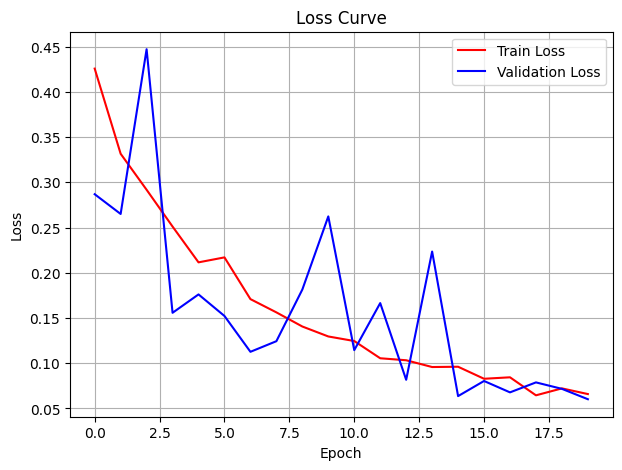

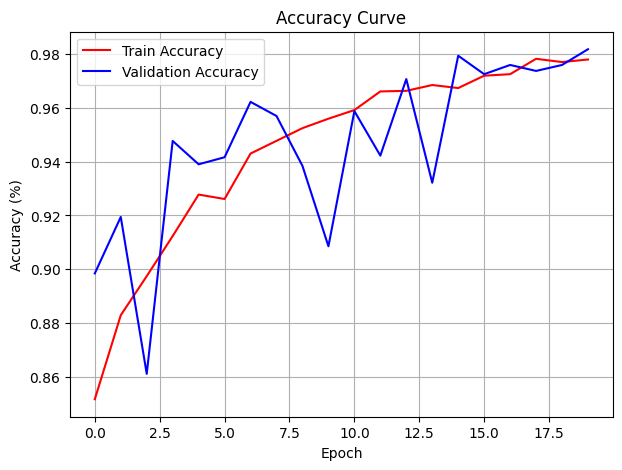

In [51]:

train_loss = history['train_loss']
val_loss = history['val_loss']
train_acc = history['train_acc']
val_acc = history['val_acc']

# ------- LOSS CURVE -------
plt.figure(figsize=(7,5))
plt.plot(train_loss, label='Train Loss', color='red')
plt.plot(val_loss, label='Validation Loss', color='blue')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# ------- ACCURACY CURVE -------
plt.figure(figsize=(7,5))
plt.plot(train_acc, label='Train Accuracy', color='red')
plt.plot(val_acc, label='Validation Accuracy', color='blue')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
model = SimpleCNN(num_classes).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/bloodcell_cnn_model.pth", map_location=device))
model.eval()


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [55]:
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy


# Compute test loss and accuracy
test_loss, test_accuracy   = evaluate(model, test_loader, criterion)


print(f"Test Loss:  {test_loss:.4f},  Test Accuracy:  {test_accuracy:.4f}")


KeyboardInterrupt: 

In [ ]:

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


# Convert Predictions and True Labels
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)


class_names = test_data.classes

# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Blood Cell Classification")
plt.show()


results_df = pd.DataFrame({
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

print(results_df)

In [ ]:

# Build simple flattened image features and train Random Forest and SVM baselines for comparison.

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

def build_flat_features(dataset, resize=(64, 64)):
    # Convert each image to a small fixed size and flatten to 1D vector as input for ML models.
    X, y = [], []
    for path, label in dataset.samples:
        img = Image.open(path).convert("RGB")
        img = img.resize(resize)
        arr = np.array(img).astype(np.float32) / 255.0  # normalise to [0,1]
        arr = arr.reshape(-1)                           # flatten H*W*3 → 1D
        X.append(arr)
        y.append(label)
    X = np.stack(X)
    y = np.array(y)
    return X, y

# use train + val for training baselines, and test for evaluation
X_train_ml, y_train_ml = build_flat_features(train_data)
X_val_ml,   y_val_ml   = build_flat_features(val_data)
X_test_ml,  y_test_ml  = build_flat_features(test_data)

# combine train and validation for stronger ML training
X_trainval_ml = np.concatenate([X_train_ml, X_val_ml], axis=0)
y_trainval_ml = np.concatenate([y_train_ml, y_val_ml], axis=0)

# standardise features to zero mean / unit variance
scaler = StandardScaler()
X_trainval_scaled = scaler.fit_transform(X_trainval_ml)
X_test_scaled     = scaler.transform(X_test_ml)

# Random Forest baseline classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_trainval_scaled, y_trainval_ml)
rf_preds = rf.predict(X_test_scaled)
rf_acc = accuracy_score(y_test_ml, rf_preds)
print(f"Random Forest Test Accuracy: {rf_acc:.4f}")

# SVM baseline classifier with RBF kernel
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_trainval_scaled, y_trainval_ml)
svm_preds = svm.predict(X_test_scaled)
svm_acc = accuracy_score(y_test_ml, svm_preds)
print(f"SVM Test Accuracy: {svm_acc:.4f}")
